# Michigan FAP PDF → CSV (Multi-Year, Multi-County)

This notebook extracts *county-level monthly totals* tables from annual Michigan FAP PDFs where **one PDF per year contains all counties (~100 pages)**.

### What it does
- Detects **county names per page** via regex on page text (using `pdfplumber`).
- Extracts the **Monthly Totals** table from each page using **Tabula** (default) or **Camelot**.
- Cleans numbers (removes `$` and commas), standardizes column names, and keeps month rows.
- Writes **per-year CSVs** and an **all-years combined CSV**.

> **Note:** For scanned PDFs, please perform OCR (e.g., with Adobe Acrobat) before running this.


## 0) Install dependencies (run if needed)
Tabula requires Java (>=8). Camelot lattice mode requires ghostscript/opencv.


In [1]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk"
os.environ["PATH"] = "/opt/homebrew/opt/openjdk/bin:" + os.environ["PATH"]


In [ ]:
# Fix "No module named 'numpy.rec'" (NumPy 2.x removed it). Run this cell once, then Kernel → Restart, then run notebook from top.
import sys
import subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "numpy<2", "-q"], check=False, timeout=120)
import numpy as np
print("NumPy:", np.__version__, "| Restart kernel (Kernel → Restart), then run the notebook again.")

In [2]:
# If your environment misses these, uncomment and run:
# !pip install pdfplumber tabula-py camelot-py[cv] pandas python-dateutil tqdm
import sys
print(sys.version)

3.10.7 (v3.10.7:6cc6b13308, Sep  5 2022, 14:02:52) [Clang 13.0.0 (clang-1300.0.29.30)]


In [5]:
%pip install "camelot-py[cv]" pdfplumber tabula-py pandas python-dateutil tqdm



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install pdfplumber



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys
!{sys.executable} -m pip install pdfplumber



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:
import pdfplumber, sys
print("pdfplumber:", pdfplumber.__version__, "| python:", sys.executable)


pdfplumber: 0.11.7 | python: /usr/local/bin/python3


In [9]:
import sys
!{sys.executable} -m pip install pdfplumber



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import pdfplumber, sys
print("pdfplumber version:", pdfplumber.__version__)
print("python:", sys.executable)


pdfplumber version: 0.11.7
python: /usr/local/bin/python3


In [11]:
import sys
!{sys.executable} -m pip install tabula-py



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
import os, subprocess

os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk"
os.environ["PATH"] = "/opt/homebrew/opt/openjdk/bin:" + os.environ["PATH"]

try:
    out = subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode()
    print(out)
except subprocess.CalledProcessError as e:
    print(e.output.decode())



openjdk version "25" 2025-09-16
OpenJDK Runtime Environment Homebrew (build 25)
OpenJDK 64-Bit Server VM Homebrew (build 25, mixed mode, sharing)



In [ ]:
import tabula
tabula.environment_info()   


Python version:
    3.10.7 (v3.10.7:6cc6b13308, Sep  5 2022, 14:02:52) [Clang 13.0.0 (clang-1300.0.29.30)]
Java version:
    openjdk version "25" 2025-09-16
OpenJDK Runtime Environment Homebrew (build 25)
OpenJDK 64-Bit Server VM Homebrew (build 25, mixed mode, sharing)
tabula-py version: 2.10.0
platform: macOS-26.2-arm64-arm-64bit
uname:
    uname_result(system='Darwin', node='HUAWEI-MATEBOOK-PRO.local', release='25.2.0', version='Darwin Kernel Version 25.2.0: Tue Nov 18 21:09:34 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8112', machine='arm64')
linux_distribution: ('Darwin', '25.2.0', '')
mac_ver: ('26.2', ('', '', ''), 'arm64')


## 1) Configure paths & options

In [14]:
import os
FAP_DIR = "/Users/jiamingzhang/Desktop/snap_project/FAP"
IN_DIR  = FAP_DIR
OUT_DIR = FAP_DIR
os.makedirs(OUT_DIR, exist_ok=True)

START_YEAR = 2015
END_YEAR   = 2023
PER_COUNTY_CSV = True

# Ensure Java path (Apple Silicon default here)
import os as _os
_os.environ.setdefault("JAVA_HOME", "/opt/homebrew/opt/openjdk")
_os.environ["PATH"] = "/opt/homebrew/opt/openjdk/bin:" + _os.environ["PATH"]
print('OUT_DIR:', OUT_DIR)

OUT_DIR: /Users/jiamingzhang/Desktop/snap_project/FAP


## 2) Helper: page area (county pages)

In [15]:
def page_area_points(pdf_path, page_no):
    import pdfplumber
    rel_area_county = (0.12, 0.06, 0.80, 0.96)  # try (0.10,0.06,0.84,0.96) if needed
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_no-1]
        H, W = page.height, page.width
    t = H*rel_area_county[0]; l = W*rel_area_county[1]; b = H*rel_area_county[2]; r = W*rel_area_county[3]
    return [t,l,b,r]

## 3) County detection (robust)

In [16]:
import re, os
def detect_counties_per_page(pdf_path, county_regex=None):
    import pdfplumber
    mi_counties = [
        'Presque Isle','Grand Traverse','St. Clair','St. Joseph','Van Buren',
        'Alcona','Alger','Allegan','Alpena','Antrim','Arenac','Baraga','Barry','Bay','Benzie',
        'Berrien','Branch','Calhoun','Cass','Charlevoix','Cheboygan','Chippewa','Clare','Clinton',
        'Crawford','Delta','Dickinson','Eaton','Emmet','Genesee','Gladwin','Gogebic',
        'Gratiot','Hillsdale','Houghton','Huron','Ingham','Ionia','Iosco','Iron','Isabella','Jackson',
        'Kalamazoo','Kalkaska','Kent','Keweenaw','Lake','Lapeer','Leelanau','Lenawee','Livingston',
        'Luce','Mackinac','Macomb','Manistee','Marquette','Mason','Mecosta','Menominee','Midland',
        'Missaukee','Monroe','Montcalm','Montmorency','Muskegon','Newaygo','Oakland','Oceana','Ogemaw',
        'Ontonagon','Osceola','Oscoda','Otsego','Ottawa','Roscommon','Saginaw','Sanilac',
        'Schoolcraft','Shiawassee','Tuscola','Washtenaw','Wayne','Wexford'
    ]
    mi_sorted = sorted(mi_counties, key=len, reverse=True)
    rx = re.compile(r"(?i)\b(?:St\.?\s+)?([A-Z][A-Za-z'\- ]+?)\s+County\b")
    page_to_county, last = {}, None
    print(f"[INFO] Scanning counties in {os.path.basename(pdf_path)} ...")
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages, start=1):
            text = page.extract_text() or ''
            name=None
            for c in mi_sorted:
                if re.search(rf"\b{re.escape(c)}\b", text, flags=re.I):
                    name=c; break
            if not name:
                m = rx.search(text)
                if m:
                    tmp = m.group(0); name = re.sub(r"(?i)\s+County\b","",tmp)
            if name:
                name = re.sub(r"\s+"," ",name).title()
                last = name
            page_to_county[i] = last
    print(f"[INFO] County detection complete. Total pages: {len(page_to_county)}")
    return page_to_county

## 4) Page extraction cascade

In [35]:
def read_tables_on_page(pdf_path, page_no, engine="tabula"):
    import os
    dfs = []
    base = os.path.basename(pdf_path)
    is_2023_trend = "2023" in base or "FY2023" in base
    if is_2023_trend:
        for lattice in [False, True]:
            try:
                import tabula
                dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=lattice, multiple_tables=True, guess=True)
                if dfs: break
            except Exception: pass
        if not dfs:
            try:
                import tabula
                single = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=False, multiple_tables=False, guess=True)
                if single and len(single) > 0 and hasattr(single[0], "shape") and single[0].shape[0] > 0:
                    dfs = single
            except Exception: pass
    if dfs:
        return dfs
    area_pts = page_area_points(pdf_path, page_no)
    # Tabula lattice + area
    try:
        import tabula
        dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=True, multiple_tables=True, area=[area_pts], guess=False)
    except Exception:
        dfs = []
    # Tabula stream + area
    if not dfs:
        try:
            import tabula
            dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=False, multiple_tables=True, area=[area_pts], guess=False)
        except Exception:
            dfs = []
    # Camelot lattice
    if not dfs:
        try:
            import camelot
            tables = camelot.read_pdf(pdf_path, pages=str(page_no), flavor="lattice", strip_text=" \n")
            dfs = [t.df for t in tables if t.df is not None]
        except Exception:
            dfs = []
    # Camelot stream
    if not dfs:
        try:
            import camelot
            tables = camelot.read_pdf(pdf_path, pages=str(page_no), flavor="stream", strip_text=" \n")
            dfs = [t.df for t in tables if t.df is not None]
        except Exception:
            dfs = []
    # Full-page fallback (no area) - for PDFs with different layout e.g. FY2023
    if not dfs:
        try:
            import tabula
            dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=True, multiple_tables=True, guess=False)
        except Exception:
            dfs = []
    if not dfs:
        try:
            import tabula
            dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=False, multiple_tables=True, guess=False)
        except Exception:
            dfs = []
    # guess=True fallback (helps trend tables e.g. FY2023 PDF)
    if not dfs:
        try:
            import tabula
            dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=True, multiple_tables=True, guess=True)
        except Exception:
            dfs = []
    if not dfs:
        try:
            import tabula
            dfs = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=False, multiple_tables=True, guess=True)
        except Exception:
            dfs = []
    # Single-table fallback (one table per page; helps some trend layouts)
    if not dfs:
        try:
            import tabula
            single = tabula.read_pdf(pdf_path, pages=str(page_no), lattice=False, multiple_tables=False, guess=True)
            if single and not (isinstance(single[0], type(None)) or (hasattr(single[0], "empty") and single[0].empty)):
                dfs = single
        except Exception:
            pass
    return dfs or []

## 5) Normalize tables (merge two-row headers)

In [36]:
def normalize_table(df):
    import re, pandas as pd
    def _is_header_row(sr):
        txt = " ".join(map(lambda x: str(x).strip(), sr.tolist()))
        nonnum = sum(1 for v in sr if not re.fullmatch(r"\$?\s*[\d,\.\-]+", str(v).strip()))
        return nonnum >= max(3, int(0.6*len(sr))) and (re.search(r"Reporting|Month|Average|Recipients|Payments|Cases", txt, re.I) is not None)
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all").copy()
    if df.shape[0] >= 2 and _is_header_row(df.iloc[0]) and _is_header_row(df.iloc[1]):
        new_cols = []
        for a,b in zip(df.iloc[0].astype(str), df.iloc[1].astype(str)):
            h = (a + " " + b).strip(); h = re.sub(r"\s+"," ",h); new_cols.append(h)
        df = df.iloc[2:].reset_index(drop=True); df.columns = new_cols
    else:
        if df.shape[0] > 0:
            first = df.iloc[0].astype(str).tolist()
            if _is_header_row(df.iloc[0]):
                df = df.iloc[1:].reset_index(drop=True); df.columns = first
    def canon(cols):
        mapping = {
            "reporting month":"Reporting Month","cases":"Cases","recipients":"Recipients",
            "adult recipients":"Adult Recipients","child recipients":"Child Recipients",
            "payments":"Payments",
            "average per case":"Average Per Case","avg per case":"Average Per Case",
            "average per person":"Average Per Person","avg per person":"Average Per Person",
            "average per recipient":"Average Per Person","avg per recipient":"Average Per Person",
            "avg recipients per case":"Avg. Recipients Per Case","avg recipients percase":"Avg. Recipients Per Case",
            "avg recips per case":"Avg. Recipients Per Case","average recipients per case":"Avg. Recipients Per Case",
        }
        out=[]
        for c in cols:
            key = re.sub(r"[^a-z0-9 ]+","", str(c).strip().lower())
            key = re.sub(r"\s+"," ", key).strip()
            if re.search(r"(avg|average).*recipients.*per.*case|recipients.*per.*case", key):
                out.append("Avg. Recipients Per Case"); continue
            if re.search(r"(avg|average).*per.*case", key):
                out.append("Average Per Case"); continue
            if re.search(r"(avg|average).*per.*(person|recipient)", key):
                out.append("Average Per Person"); continue
            out.append(mapping.get(key, str(c)))
        return out
    df.columns = canon(df.columns)
    desired = ["Reporting Month","Cases","Recipients","Adult Recipients","Child Recipients","Payments",
               "Average Per Case","Average Per Person","Avg. Recipients Per Case"]
    keep = [c for c in desired if c in df.columns]
    if not keep: return pd.DataFrame()
    df = df[keep].copy()
    if "Reporting Month" in df.columns:
        months = ["October","November","December","January","February","March","April","May","June","July","August","September","Monthly Avg",
                  "Oct","Nov","Dec","Jan","Feb","Mar","Apr","Jun","Jul","Aug","Sep"]
        pat = "|".join(map(re.escape, months))
        df["Reporting Month"] = df["Reporting Month"].astype(str).str.replace(r"\s+"," ", regex=True).str.strip()
        df = df[df["Reporting Month"].str.contains(pat, case=False, na=False)].copy()
        # Drop "Monthly Avg." rows so we keep only actual month rows (for trend tables)
        df = df[~df["Reporting Month"].str.strip().str.lower().eq("monthly avg.")].copy()
    def clean_number(x):
        if pd.isna(x): return pd.NA
        s = str(x).strip()
        if s in {"","—","-","NA","N/A"}: return pd.NA
        s = re.sub(r"[\$,]","",s); s = re.sub(r"[^0-9.\-]","",s)
        try: return float(s) if s else pd.NA
        except: return pd.NA
    for c in [c for c in df.columns if c != "Reporting Month"]:
        df[c] = df[c].apply(clean_number)
    # Ensure all desired columns exist (even if missing in some PDFs)
    for c in desired:
        if c not in df.columns:
            df[c] = pd.NA
    df = df[desired]
    return df

def normalize_table_trend(raw_df):
    """Trend PDF (FY2023): section/month is in COLUMN 1 (not 0); data columns may be offset."""
    import re, pandas as pd
    df = raw_df.dropna(axis=1, how="all").dropna(axis=0, how="all").copy()
    for c in df.columns:
        df[c] = df[c].astype(str).str.replace("\r", " ", regex=False).str.strip()
    if df.empty or df.shape[1] < 3: return pd.DataFrame()
    # Section/month usually in column 1; fallback to column 0
    col1 = df.iloc[:, 1] if df.shape[1] > 1 else df.iloc[:, 0]
    col1 = col1.astype(str).str.replace("\r", " ", regex=False).str.strip()
    col0 = df.iloc[:, 0].astype(str).str.replace("\r", " ", regex=False).str.strip() if df.shape[1] > 0 else col1
    fy_rx = re.compile(r"Fiscal\s+Year\s+(20\d{2})", re.I)
    month_rx = re.compile(r"(Oct|Nov|Dec|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep)[a-z]*\s*'?(\d{2})?", re.I)
    current_fy = None
    data_rows = []
    for i in range(len(df)):
        v1 = col1.iloc[i] if i < len(col1) else ""
        v0 = col0.iloc[i] if i < len(col0) else ""
        if str(v1) == "nan" or (hasattr(df, "iloc") and df.shape[1] > 1 and pd.isna(df.iloc[i, 1])): v1 = ""
        val = str(v1).strip() or str(v0).strip()
        m_fy = fy_rx.search(val)
        if not m_fy and v0: m_fy = fy_rx.search(str(v0))
        if m_fy:
            current_fy = int(m_fy.group(1))
            continue
        if current_fy is None: continue
        if "monthly" in val.lower() and "avg" in val.lower(): continue
        if month_rx.search(val):
            data_rows.append((current_fy, i))
    if not data_rows: return pd.DataFrame()
    # Data row: col1=Month, 2=Cases, 3=Recip, 4=Adult, 5=Child, 6=NaN(skip), 7=Payments, 8=AvgCase, 9=AvgPerson, 10=AvgRecip
    desired = ["Reporting Month", "Cases", "Recipients", "Adult Recipients", "Child Recipients", "Payments", "Average Per Case", "Average Per Person", "Avg. Recipients Per Case"]
    pos_map = [(1, "Reporting Month"), (2, "Cases"), (3, "Recipients"), (4, "Adult Recipients"), (5, "Child Recipients"), (7, "Payments"), (8, "Average Per Case"), (9, "Average Per Person"), (10, "Avg. Recipients Per Case")]
    def clean_num(x):
        if pd.isna(x): return pd.NA
        s = re.sub(r"[\$,]", "", str(x).strip()); s = re.sub(r"[^0-9.\-]", "", s)
        try: return float(s) if s else pd.NA
        except: return pd.NA
    rows = []
    for fy, i in data_rows:
        row = df.iloc[i]
        rec = {"year": fy, "Reporting Month": row.iloc[1] if len(row) > 1 else ""}
        for pos, name in pos_map:
            if name == "Reporting Month": continue
            if pos < len(row): rec[name] = clean_num(row.iloc[pos])
            else: rec[name] = pd.NA
        rows.append(rec)
    out = pd.DataFrame(rows)
    out = out[["year"] + [c for c in desired if c in out.columns]]
    return out

def normalize_table_trend_simple(raw_df):
    """Fallback: first row is header, rest are data (Oct '23 style)."""
    df = raw_df.dropna(axis=1, how="all").dropna(axis=0, how="all").copy()
    if df.shape[0] < 2 or df.shape[1] < 3: return pd.DataFrame()
    df.columns = df.iloc[0].astype(str).tolist()[:df.shape[1]]
    df = df.iloc[1:].reset_index(drop=True)
    return normalize_table(df)


## 6) Process one year & batch

In [37]:
import re, glob, pandas as pd, os

def _fiscal_year_from_reporting_month(series):
    """Parse fiscal year from 'Reporting Month' like October '23, January '24 (trend-table format)."""
    month_num = {"october":10,"november":11,"december":12,"january":1,"february":2,"march":3,"april":4,"may":5,"june":6,"july":7,"august":8,"september":9,
                 "oct":10,"nov":11,"dec":12,"jan":1,"feb":2,"mar":3,"apr":4,"jun":6,"jul":7,"aug":8,"sep":9}
    out = []
    for v in series.astype(str).str.strip():
        m = re.search(r"(october|november|december|january|february|march|april|may|june|july|august|september|oct|nov|dec|jan|feb|mar|apr|jun|jul|aug|sep)\s*'?(\d{2})?", v, re.I)
        if not m or not m.group(2):
            out.append(pd.NA); continue
        mn = month_num.get(m.group(1).lower(), None)
        yy = int(m.group(2))
        if mn is None: out.append(pd.NA); continue
        fy = (2000 + yy + 1) if mn in (10, 11, 12) else (2000 + yy)
        out.append(fy)
    return pd.Series(out, index=series.index)

def process_year_pdf(pdf_path, out_dir, year, write_per_county=False):
    page_to_county = detect_counties_per_page(pdf_path)
    rows = []
    is_trend_doc = (year == 2023)
    for page_no, county in page_to_county.items():
        # For 2023 trend PDF, process page 1 (state trend table); for other years skip title page
        if page_no == 1 and not is_trend_doc:
            continue
        page_dfs = read_tables_on_page(pdf_path, page_no)
        total_rows = 0
        # State-level trend table on page 1 has no county; label as Entire State
        county_assign = "Entire State" if (is_trend_doc and page_no == 1) else (county if county else pd.NA)
        for idx, raw in enumerate(page_dfs):
            try:
                raw = pd.DataFrame(raw)
                if is_trend_doc:
                    df = normalize_table_trend(raw)
                    if df.empty: df = normalize_table(raw.copy())
                    if df.empty: df = normalize_table_trend_simple(raw)
                    if not df.empty and "year" not in df.columns and "Reporting Month" in df.columns:
                        df["year"] = _fiscal_year_from_reporting_month(df["Reporting Month"])
                        df = df[df["year"].notna()].copy(); df["year"] = df["year"].astype(int)
                    elif not df.empty and "year" not in df.columns: df["year"] = year
                else:
                    df = normalize_table(raw.copy())
                    if not df.empty: df["year"] = year
                if df.empty: continue
                if "year" not in df.columns:
                    df["year"] = year
                df["county"], df["page_no"], df["table_index"] = county_assign, page_no, idx
                rows.append(df); total_rows += len(df)
            except Exception:
                pass
        print(f"  [page {page_no:>2}] county={county or 'N/A'} rows={total_rows}")
    if not rows: return pd.DataFrame()
    out = pd.concat(rows, ignore_index=True).drop_duplicates()
    out["county"] = out["county"].ffill()
    if write_per_county:
        for (cty, yr), g in out.groupby(["county", "year"], dropna=False):
            safe = "Unknown" if pd.isna(cty) else re.sub(r"[^A-Za-z0-9_]+","_", str(cty))
            g.to_csv(os.path.join(out_dir, f"FAP_{yr}_{safe}.csv"), index=False)
    out_year_path = os.path.join(out_dir, f"FAP_{year}_ALL_COUNTIES.csv"); out.to_csv(out_year_path, index=False)
    return out

def run_batch(in_dir, out_dir, start_year, end_year, per_county_csv=True):
    os.makedirs(out_dir, exist_ok=True)
    pattern = os.path.join(in_dir, "FY*-Annual_FAP.pdf")
    pdfs = sorted(glob.glob(pattern))
    if not pdfs: raise FileNotFoundError(f"No PDFs matched: {pattern}")
    combined = []
    for p in pdfs:
        base = os.path.basename(p)
        m = re.search(r"(?:FY)?(20\d{2})", base)
        if not m: 
            print(f"[WARN] Skip (no year): {base}"); continue
        year = int(m.group(1))
        if not (start_year <= year <= end_year): continue
        print(f"[INFO] Processing {base} (year={year})")
        dfy = process_year_pdf(p, out_dir, year, write_per_county=per_county_csv)
        if dfy is None or dfy.empty: 
            print(f"[WARN] No tables for {year}"); continue
        combined.append(dfy)
    if not combined:
        print("[WARN] Nothing extracted."); return pd.DataFrame()
    big = pd.concat(combined, ignore_index=True).drop_duplicates()
    big["county"] = big["county"].ffill()
    combined_path = os.path.join(out_dir, "FAP_ALL_YEARS_COMBINED.csv"); big.to_csv(combined_path, index=False)
    print(f"[DONE] Wrote {combined_path} rows={len(big)}"); return big

## 7) Quick single-year test (edit years if you like)

## Debug: 2023 PDF extraction (run if 2023 fails)

Run this to see what Tabula extracts from page 2 of the 2023 PDF. If "Tables found: 0", the PDF layout is not detected; try opening the PDF in Adobe and re-saving, or use a different machine.

## Extract 2023 only (trend-table PDF)

Processes only FY2023-Annual_FAP.pdf (trend format: FY2024/2025/2026 with "October '23" style months). Output goes to the same FAP folder. Run Section 4 (read_tables_on_page), Section 5 (normalize_table), and Section 6 (process_year_pdf) first.

In [38]:
# Debug: what does Tabula see on 2023 PDF page 2? (Run Section 1 first for IN_DIR)
import os
import tabula
pdf_2023 = os.path.join(IN_DIR, "FY2023-Annual_FAP.pdf")
if os.path.isfile(pdf_2023):
    for lattice, guess in [(True, False), (True, True), (False, True)]:
        try:
            dfs = tabula.read_pdf(pdf_2023, pages="2", lattice=lattice, multiple_tables=True, guess=guess)
            print(f"lattice={lattice} guess={guess} -> {len(dfs)} table(s)")
            for i, d in enumerate(dfs):
                print(f"  Table {i}: shape {d.shape}"); display(d.head(8))
        except Exception as e:
            print(f"lattice={lattice} guess={guess} -> error: {e}")
else:
    print("FY2023-Annual_FAP.pdf not found in IN_DIR")

lattice=True guess=False -> 2 table(s)
  Table 0: shape (36, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


  Table 1: shape (35, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


lattice=True guess=True -> 2 table(s)
  Table 0: shape (36, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


  Table 1: shape (35, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


lattice=False guess=True -> 2 table(s)
  Table 0: shape (36, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


  Table 1: shape (35, 11)


,"Trend Table: 24\rFood Assistance Program ( FAP ): Trend Information\rFiscal Years 2024, 2025 and 2026\rAverage PerAverage PerAvg. Recipients\rReporting MonthCasesRecipientsAdult RecipientsChild RecipientsPayments\rCasePersonPer Case",Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,NaN,Payments,Average Per\rCase,Average Per\rPerson,Avg. Recipients\rPer Case,NaN
1,Alcona County\rFiscal Year 2024\rOctober '2378...,Alcona County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fiscal Year 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,October '23,783,"1,378",963,415.0,NaN,"$221,057",$282,$160,1.76
4,NaN,November '23,772,"1,361",950,411.0,NaN,"$218,711",$283,$161,1.76
5,NaN,December '23,783,"1,379",967,412.0,NaN,"$223,222",$285,$162,1.76
6,NaN,January '24,779,"1,374",969,405.0,NaN,"$217,379",$279,$158,1.76
7,NaN,February '24,798,"1,387",980,407.0,NaN,"$219,927",$276,$159,1.74


In [39]:
# Extract 2023 only: same paths as Section 1
import os
pdf_2023 = os.path.join(IN_DIR, "FY2023-Annual_FAP.pdf")
if not os.path.isfile(pdf_2023):
    raise FileNotFoundError(f"Not found: {pdf_2023}")

df_2023 = process_year_pdf(pdf_2023, OUT_DIR, 2023, write_per_county=PER_COUNTY_CSV)
if df_2023 is not None and not df_2023.empty:
    print(f"[DONE] 2023 extracted: {len(df_2023)} rows")
    display(df_2023.head(20))
    print("counties:", df_2023["county"].nunique())
else:
    print("[WARN] No tables extracted for 2023; check PDF layout or full-page fallback.")

[INFO] Scanning counties in FY2023-Annual_FAP.pdf ...
[INFO] County detection complete. Total pages: 85
  [page  2] county=Alcona rows=54
  [page  3] county=Alger rows=54
  [page  4] county=Allegan rows=54
  [page  5] county=Alpena rows=54
  [page  6] county=Antrim rows=54
  [page  7] county=Arenac rows=54
  [page  8] county=Baraga rows=54
  [page  9] county=Barry rows=54
  [page 10] county=Bay rows=54
  [page 11] county=Benzie rows=54
  [page 12] county=Berrien rows=54
  [page 13] county=Branch rows=54
  [page 14] county=Calhoun rows=54
  [page 15] county=Cass rows=54
  [page 16] county=Charlevoix rows=54
  [page 17] county=Cheboygan rows=54
  [page 18] county=Chippewa rows=54
  [page 19] county=Clare rows=54
  [page 20] county=Clinton rows=54
  [page 21] county=Crawford rows=54
  [page 22] county=Delta rows=54
  [page 23] county=Dickinson rows=54
  [page 24] county=Eaton rows=54
  [page 25] county=Emmet rows=54
  [page 26] county=Genesee rows=54
  [page 27] county=Gladwin rows=54
  [

,year,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,Payments,Average Per Case,Average Per Person,Avg. Recipients Per Case,county,page_no,table_index
0,2024,October '23,783.0,1378.0,963.0,415.0,221057.0,282.0,160.0,1.76,Alcona,2,0
1,2024,November '23,772.0,1361.0,950.0,411.0,218711.0,283.0,161.0,1.76,Alcona,2,0
2,2024,December '23,783.0,1379.0,967.0,412.0,223222.0,285.0,162.0,1.76,Alcona,2,0
3,2024,January '24,779.0,1374.0,969.0,405.0,217379.0,279.0,158.0,1.76,Alcona,2,0
4,2024,February '24,798.0,1387.0,980.0,407.0,219927.0,276.0,159.0,1.74,Alcona,2,0
5,2024,March '24,797.0,1388.0,987.0,401.0,218650.0,274.0,158.0,1.74,Alcona,2,0
6,2024,April '24,795.0,1397.0,993.0,404.0,218558.0,275.0,156.0,1.76,Alcona,2,0
7,2024,May '24,783.0,1355.0,972.0,383.0,215620.0,275.0,159.0,1.73,Alcona,2,0
8,2024,June '24,784.0,1373.0,980.0,393.0,218299.0,278.0,159.0,1.75,Alcona,2,0
9,2024,July '24,785.0,1381.0,981.0,400.0,217620.0,277.0,158.0,1.76,Alcona,2,0


counties: 84


In [24]:
import pandas as pd
# Full batch 2015–2023 (uses START_YEAR, END_YEAR from Section 1)
big_test = run_batch(IN_DIR, OUT_DIR, START_YEAR, END_YEAR, per_county_csv=True)
if isinstance(big_test, pd.DataFrame) and not big_test.empty:
    display(big_test.head(20))
    print('unique counties:', big_test['county'].nunique())
    print('pages captured:', big_test['page_no'].nunique())
    print('columns:', list(big_test.columns))

[INFO] Processing FY2015-Annual_FAP.pdf (year=2015)
[INFO] Scanning counties in FY2015-Annual_FAP.pdf ...
[INFO] County detection complete. Total pages: 85
  [page  2] county=Alcona rows=13
  [page  3] county=Alger rows=13
  [page  4] county=Allegan rows=13
  [page  5] county=Alpena rows=13
  [page  6] county=Antrim rows=13
  [page  7] county=Arenac rows=13
  [page  8] county=Baraga rows=13
  [page  9] county=Barry rows=13
  [page 10] county=Bay rows=13
  [page 11] county=Benzie rows=13
  [page 12] county=Berrien rows=13
  [page 13] county=Branch rows=13
  [page 14] county=Calhoun rows=13
  [page 15] county=Cass rows=13
  [page 16] county=Charlevoix rows=13
  [page 17] county=Cheboygan rows=13
  [page 18] county=Chippewa rows=13
  [page 19] county=Clare rows=13
  [page 20] county=Clinton rows=13
  [page 21] county=Crawford rows=13
  [page 22] county=Delta rows=13
  [page 23] county=Dickinson rows=13
  [page 24] county=Eaton rows=13
  [page 25] county=Emmet rows=13
  [page 26] county=Ge

,Reporting Month,Cases,Recipients,Adult Recipients,Child Recipients,Payments,Average Per Case,Average Per Person,Avg. Recipients Per Case,year,county,page_no,table_index
0,NaN,806.0,1479.0,1019.0,460.0,175887.0,218.0,119.0,1.83,2015,Alcona,2,0
1,NaN,797.0,1476.0,1013.0,463.0,174909.0,219.0,119.0,1.85,2015,Alcona,2,0
2,NaN,784.0,1460.0,1000.0,460.0,171119.0,218.0,117.0,1.86,2015,Alcona,2,0
3,NaN,789.0,1432.0,1004.0,428.0,165684.0,210.0,116.0,1.81,2015,Alcona,2,0
4,NaN,793.0,1447.0,1008.0,439.0,166483.0,210.0,115.0,1.82,2015,Alcona,2,0
5,NaN,786.0,1445.0,998.0,447.0,169121.0,215.0,117.0,1.84,2015,Alcona,2,0
6,NaN,795.0,1447.0,1006.0,441.0,170280.0,214.0,118.0,1.82,2015,Alcona,2,0
7,NaN,776.0,1423.0,989.0,434.0,166771.0,215.0,117.0,1.83,2015,Alcona,2,0
8,NaN,766.0,1393.0,979.0,414.0,159911.0,209.0,115.0,1.82,2015,Alcona,2,0
9,NaN,758.0,1392.0,969.0,423.0,155057.0,205.0,111.0,1.84,2015,Alcona,2,0


unique counties: 84
pages captured: 84
columns: ['Reporting Month', 'Cases', 'Recipients', 'Adult Recipients', 'Child Recipients', 'Payments', 'Average Per Case', 'Average Per Person', 'Avg. Recipients Per Case', 'year', 'county', 'page_no', 'table_index']


## GreenBook: 2022-10 to 2023-09 (pages 77, 78, 79)

Fills 2022–2023 data: name PDFs as `2022_10_GreenBook.pdf` … `2023_09_GreenBook.pdf`. Each PDF is read **on pages 77, 78, and 79**. Table layout: first column = county, then Cases, Recipients, Payments, etc.

In [4]:
import pandas as pd
import os
import re
import glob
from pathlib import Path
import tabula

GREENBOOK_DIR = Path(r"/Users/jiamingzhang/Desktop/snap_project/FAP")
GREENBOOK_PAGES = [77, 78, 79]
GREENBOOK_OUT = GREENBOOK_DIR / "FAP_GreenBook_2022_10_to_2023_9.csv"

def _normalize_gb(raw_df):
    """Pages 77-79: Tabula often puts title in col0, county in col1, then Cases, Recipients, etc."""
    df = raw_df.dropna(axis=1, how="all").dropna(axis=0, how="all").copy()
    if df.empty or df.shape[1] < 2:
        return pd.DataFrame()
    for c in df.columns:
        df[c] = df[c].astype(str).str.replace("\r", " ", regex=False).str.strip()
    # Find which column has county names: look for "County" in first row or col with "Alcona"/"Entire State"
    county_col = 0
    for j in range(min(3, df.shape[1])):
        vals = df.iloc[:5, j].astype(str).str.strip()
        if vals.str.contains("County", case=False, na=False).any() or vals.str.contains("Alcona|Entire State", case=False, na=False).any():
            county_col = j
            break
    header_idx = 0
    for i in range(min(5, len(df))):
        if "County" in " ".join(df.iloc[i].astype(str).tolist()) and "Cases" in " ".join(df.iloc[i].astype(str).tolist()):
            header_idx = i
            break
    df = df.iloc[header_idx + 1:].reset_index(drop=True)
    df["county"] = df.iloc[:, county_col].astype(str).str.strip()
    df = df[~df["county"].str.lower().isin(["", "nan", "county"])].copy()
    def canon(s):
        s = re.sub(r"[^a-z0-9 ]+", "", str(s).lower().strip())
        return re.sub(r"\s+", " ", s).strip()
    name_map = {"cases": "Cases", "recipients": "Recipients", "adult recipients": "Adult Recipients", "child recipients": "Child Recipients", "payments": "Payments", "average per case": "Average Per Case", "avg per case": "Average Per Case", "average per person": "Average Per Person", "avg per person": "Average Per Person", "avg. recipients per case": "Avg. Recipients Per Case", "avg recipients per case": "Avg. Recipients Per Case"}
    rename_map = {c: name_map.get(canon(c), c) for c in df.columns if str(c).lower() not in ["county", "counties"]}
    df = df.rename(columns=rename_map)
    # Decide positional mapping from current columns (before adding any); else Tabula "Unnamed" columns never get mapped.
    pos_names = ["Cases", "Recipients", "Adult Recipients", "Child Recipients", "Payments", "Average Per Case", "Average Per Person", "Avg. Recipients Per Case"]
    has_any_standard = any(c in df.columns for c in pos_names)
    if (not has_any_standard) and df.shape[1] > county_col + 1:
        for k, name in enumerate(pos_names):
            idx = county_col + 1 + k
            if idx < df.shape[1]:
                ser = df.iloc[:, idx].astype(str).str.replace(r"[\$,]", "", regex=True).str.replace(r"[^0-9.\-]", "", regex=True)
                df[name] = pd.to_numeric(ser, errors="coerce")
    for col in pos_names:
        if col not in df.columns:
            df[col] = pd.NA
    def clean_num(x):
        if pd.isna(x):
            return pd.NA
        s = re.sub(r"[\$,]", "", str(x).strip())
        s = re.sub(r"[^0-9.\-]", "", s)
        try:
            return float(s) if s else pd.NA
        except Exception:
            return pd.NA
    for col in pos_names:
        if col in df.columns:
            df[col] = df[col].apply(clean_num)
    desired = ["county", "Cases", "Recipients", "Adult Recipients", "Child Recipients", "Payments", "Average Per Case", "Average Per Person", "Avg. Recipients Per Case"]
    out = df[[c for c in desired if c in df.columns]].copy()
    out = out[out["county"].astype(str).str.strip().str.lower() != "entire state"].copy()
    out = out[~out["county"].astype(str).str.lower().str.contains("footnote|case and recipient totals", na=False, regex=True)].copy()
    num_cols = [c for c in ["Cases", "Recipients", "Payments"] if c in out.columns]
    if num_cols:
        out = out[out[num_cols].notna().any(axis=1)].copy()
    out["county"] = out["county"].astype(str).str.strip().str.title()
    return out if len(out) > 0 else pd.DataFrame()

def extract_one_greenbook(pdf_path, year, month):
    """Read pages 77 and 78 of one GreenBook PDF; return normalized DataFrame or empty."""
    path_str = str(Path(pdf_path).resolve())
    all_tables = []
    # 1) stream=True correctly splits pages 77–79 (county often in col 2)
    try:
        dfs = tabula.read_pdf(path_str, pages="77,78,79", stream=True, multiple_tables=True, guess=True)
        if dfs:
            all_tables.extend(dfs)
    except Exception as e:
        pass
    # 2) Read each page with lattice=False
    if not all_tables:
        for page_no in GREENBOOK_PAGES:
            try:
                dfs = tabula.read_pdf(path_str, pages=str(page_no), lattice=False, multiple_tables=True, guess=True)
                if dfs:
                    all_tables.extend(dfs)
            except Exception:
                pass
    # 3) Single table per page fallback
    if not all_tables:
        for page_no in GREENBOOK_PAGES:
            try:
                single = tabula.read_pdf(path_str, pages=str(page_no), lattice=False, multiple_tables=False, guess=True)
                if single and len(single) > 0:
                    all_tables.extend(single)
            except Exception:
                pass
    rows = []
    fy = year + 1 if month >= 10 else year
    for raw in all_tables:
        df = pd.DataFrame(raw)
        if df.empty or df.shape[1] < 2:
            continue
        norm = _normalize_gb(df.copy())
        if norm.empty:
            continue
        if "county" not in norm.columns:
            norm["county"] = pd.NA
        norm["year"] = fy
        norm["month"] = month
        rows.append(norm)
    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, ignore_index=True)

# PDFs: 2022_10_GreenBook.pdf ... 2023_09_GreenBook.pdf
pattern = str(GREENBOOK_DIR / "*GreenBook*.pdf")
pdf_files = sorted(glob.glob(pattern))
if not pdf_files:
    print("[ERROR] No GreenBook PDFs found. Place 2022_10_GreenBook.pdf etc. in:", GREENBOOK_DIR)
else:
    # Quick self-check: can Tabula read page 77 of first PDF
    _test_path = str(Path(pdf_files[0]).resolve())
    try:
        _test = tabula.read_pdf(_test_path, pages="77", stream=True, multiple_tables=True, guess=True)
        print("Self-check: Tabula page 77 ->", len(_test) if _test else 0, "tables (if 0, check Java and PDF)")
    except Exception as _e:
        print("Self-check: Tabula error ->", _e)
combined = []
for p in pdf_files:
    base = os.path.basename(p)
    m = re.match(r"(\d{4})_(\d{1,2})_.*GreenBook", base, re.I)
    if not m:
        continue
    year, month = int(m.group(1)), int(m.group(2))
    if year == 2022 and month < 10:
        continue
    if year == 2023 and month > 9:
        continue
    if not (2022 <= year <= 2023 and 1 <= month <= 12):
        continue
    print("[INFO]", base, "-> FY%d (cal %d-%02d) pages %s" % (year + 1 if month >= 10 else year, year, month, GREENBOOK_PAGES))
    one = extract_one_greenbook(p, year, month)
    if one.empty:
        print("  [WARN] No tables from pages", GREENBOOK_PAGES, "- If path is correct, ensure Java is installed and tabula can read this PDF")
        continue
    combined.append(one)

if not combined:
    print("[WARN] No GreenBook data extracted. Put 2022_10_GreenBook.pdf ... 2023_09_GreenBook.pdf in", GREENBOOK_DIR)
else:
    greenbook_df = pd.concat(combined, ignore_index=True).drop_duplicates()
    if "county" not in greenbook_df.columns:
        greenbook_df["county"] = pd.NA
    greenbook_df["county"] = greenbook_df.groupby(["year", "month"], group_keys=False)["county"].ffill()
    month_order = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    greenbook_df["_sort_key"] = greenbook_df["month"].map(lambda x: month_order.index(x) if x in month_order else 99)
    greenbook_df = greenbook_df.sort_values(["county", "year", "_sort_key"]).drop(columns=["_sort_key"], errors="ignore")
    greenbook_df.to_csv(GREENBOOK_OUT, index=False, encoding="utf-8-sig")
    print("[DONE] Wrote", GREENBOOK_OUT, "rows=%d" % len(greenbook_df))
    try:
        from IPython.display import display
        display(greenbook_df.head(15))
    except NameError:
        print(greenbook_df.head(15).to_string())

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'
Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Error from tabula-java:
The operation couldn’t be completed. Unable to locate a Java 

Self-check: Tabula error -> Command '['java', '-Djava.awt.headless=true', '-Dfile.encoding=UTF8', '-jar', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tabula/tabula-1.0.5-jar-with-dependencies.jar', '--pages', '77', '--stream', '--guess', '--format', 'JSON', '/Users/jiamingzhang/Desktop/snap_project/FAP/2022_10_GreenBook.pdf']' returned non-zero exit status 1.
[INFO] 2022_10_GreenBook.pdf -> FY2023 (cal 2022-10) pages [77, 78, 79]


ModuleNotFoundError: No module named 'numpy.rec'

In [61]:
import pandas as pd
from pathlib import Path

# ========= Paths =========
base_dir = Path(r"/Users/jiamingzhang/Desktop/snap_project/FAP")
out_path = base_dir / "FAP_ALL_YEARS_COMBINED_MERGED.csv"
# Main batch output first; then any per-year or legacy files (only existing files are read)
candidates = [
    base_dir / "FAP_ALL_YEARS_COMBINED.csv",
    base_dir / "FAP_2023_ALL_COUNTIES.csv",
    base_dir / "FAP_GreenBook_2022_10_to_2023_9.csv",
    base_dir / "FAP_ALL_YEARS_COMBINED2015-2016.csv",
    base_dir / "FAP_2017_ALL_COUNTIES.csv",
]
files_to_read = [p for p in candidates if p.exists()]
if not files_to_read:
    raise FileNotFoundError("No FAP CSV files found in " + str(base_dir))

# ========= 1) Read and concatenate =========
dfs = []
for p in files_to_read:
    df = pd.read_csv(p, encoding="utf-8-sig", low_memory=False)
    # Lowercase column names
    df.columns = [c.strip().lower() for c in df.columns]
    # Normalize county names
    df["county"] = df["county"].astype(str).str.strip().str.title()
    # Coerce year to integer
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    # Track source file for later logic
    df["_source_file"] = p.name
    # Preserve order for stable grouping
    df["_order"] = range(len(df))
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# ========= 2) Drop invalid county names (keep NA/blank for later fill) =========
if "county" not in df.columns:
    df["county"] = pd.NA
bad_pattern = r"^x-|unassigned|assigned"
df = df[~df["county"].str.contains(bad_pattern, case=False, regex=True, na=False)].copy()

# ========= 3) Drop average/total rows =========
# Each county x year should have 12 month rows; drop 13th (Average/Total) if present.
df = df.sort_values(["county", "year", "_order"]).copy()
df["_rank"] = df.groupby(["county", "year"]).cumcount() + 1
df = df[df["_rank"] <= 12].copy()

# ========= 4) Fiscal month (1..12) and map to calendar =========
# Process data with existing month (GreenBook) and without month (main FAP) separately.
df["fy_orig"] = df["year"].copy()

# Identify rows that already have month (from GreenBook)
has_month_mask = df["month"].notna() if "month" in df.columns else pd.Series([False] * len(df), index=df.index)

processed_dfs = []

# Process rows WITHOUT month (main FAP data)
if not has_month_mask.all():
    df_no_month = df[~has_month_mask].copy()
    
    # Compute fiscal_month from order within group (1..12: Oct=1, Nov=2, ..., Sep=12)
    df_no_month["fiscal_month"] = df_no_month.groupby(["county", "year"])["_order"].rank(method="first").astype(int)
    
    # Try to parse from "Reporting Month" column if it exists
    if "reporting month" in df_no_month.columns:
        month_map = {
            "october": 10, "november": 11, "december": 12,
            "january": 1, "february": 2, "march": 3,
            "april": 4, "may": 5, "june": 6,
            "july": 7, "august": 8, "september": 9
        }
        df_no_month["_parsed_month"] = df_no_month["reporting month"].astype(str).str.lower().str.strip().map(month_map)
        # Use parsed month if available, otherwise use fiscal_month mapping
        F2C_MONTH = {1:10, 2:11, 3:12, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9}
        df_no_month["month"] = df_no_month["_parsed_month"].fillna(df_no_month["fiscal_month"].map(F2C_MONTH)).astype("Int64")
        df_no_month = df_no_month.drop(columns=["_parsed_month"], errors="ignore")
    else:
        # Fiscal month -> calendar month mapping
        F2C_MONTH = {1:10, 2:11, 3:12, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9}
        df_no_month["month"] = df_no_month["fiscal_month"].map(F2C_MONTH).astype("Int64")
    
    # Calendar year: fiscal months 1–3 (Oct–Dec) = prior year; 4–12 = current year
    df_no_month["year"] = (df_no_month["fy_orig"] - (df_no_month["fiscal_month"] <= 3).astype("Int64")).astype("Int64")
    
    processed_dfs.append(df_no_month)

# Process rows WITH month (GreenBook data)
if has_month_mask.any():
    df_with_month = df[has_month_mask].copy()
    
    # Month already exists (from GreenBook). Adjust year: months 10-12 belong to prior calendar year.
    # GreenBook data: year=2023, month=10/11/12 -> calendar year should be 2022
    #                 year=2023, month=1-9 -> calendar year should be 2023
    df_with_month["month"] = pd.to_numeric(df_with_month["month"], errors="coerce").astype("Int64")
    df_with_month["year"] = (df_with_month["fy_orig"] - (df_with_month["month"] >= 10).astype("Int64")).astype("Int64")
    
    processed_dfs.append(df_with_month)

# Recombine processed dataframes
df = pd.concat(processed_dfs, ignore_index=True) if processed_dfs else df

# Build calendar date
df["date_cal"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01",
    format="%Y-%m-%d",
    errors="coerce"
)

# ========= 6) Dedupe by county x year x month =========
df = df.sort_values(["county", "date_cal", "_order"])
df = df[~df.duplicated(["county", "year", "month"], keep="first")]

# ========= 7) Drop temp columns and save =========
df = df.drop(columns=[c for c in ["page_no", "table_index", "_order", "_rank", "fiscal_month", "_source_file"] if c in df.columns])
front = ["county", "fy_orig", "year", "month", "date_cal"]
df = df[front + [c for c in df.columns if c not in front]]

df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Saved to:", out_path)
print("Final shape:", df.shape)
print("Date range:", df["date_cal"].min(), "→", df["date_cal"].max())
print("Counties:", df["county"].nunique())
print(df.head(12)[["county","fy_orig","year","month","date_cal"]])


Saved to: /Users/jiamingzhang/Desktop/snap_project/FAP/FAP_ALL_YEARS_COMBINED_MERGED.csv
Final shape: (11166, 14)
Date range: 2014-10-01 00:00:00 → 2026-03-01 00:00:00
Counties: 83
    county  fy_orig  year  month   date_cal
0   Alcona     2015  2014     10 2014-10-01
1   Alcona     2015  2014     11 2014-11-01
2   Alcona     2015  2014     12 2014-12-01
3   Alcona     2015  2015      1 2015-01-01
4   Alcona     2015  2015      2 2015-02-01
5   Alcona     2015  2015      3 2015-03-01
6   Alcona     2015  2015      4 2015-04-01
7   Alcona     2015  2015      5 2015-05-01
8   Alcona     2015  2015      6 2015-06-01
9   Alcona     2015  2015      7 2015-07-01
10  Alcona     2015  2015      8 2015-08-01
11  Alcona     2015  2015      9 2015-09-01


In [62]:
import pandas as pd
from pathlib import Path

# Quick sanity checks for merged FAP data
base_dir = Path(r"/Users/jiamingzhang/Desktop/snap_project/FAP")
merged_path = base_dir / "FAP_ALL_YEARS_COMBINED_MERGED.csv"

df = pd.read_csv(merged_path, parse_dates=["date_cal"], low_memory=False)

print("=== Basic shape ===")
print("Rows:", len(df))
print("Columns:", list(df.columns))

print("\n=== Year / month coverage ===")
print("Year range:", int(df["year"].min()), "→", int(df["year"].max()))
print("Distinct months:", sorted(df["month"].dropna().unique().tolist()))

print("\n=== Per-county year/month counts (should be ≤ 12) ===")
check = df.groupby(["county", "year"], dropna=False)["month"].nunique().reset_index(name="n_months")
print(check[check["n_months"] != 12].head(20))

print("\n=== Duplicate county-year-month rows ===")
dups = df.duplicated(["county", "year", "month"], keep=False)
print("#duplicates:", dups.sum())
if dups.any():
    print(df.loc[dups, ["county", "year", "month", "date_cal"]].head(20))

print("\n=== Sample rows ===")
print(df.sort_values(["county", "year", "month"]).head(20)[["county", "year", "month", "date_cal"]])

=== Basic shape ===
Rows: 10917
Columns: ['county', 'fy_orig', 'year', 'month', 'date_cal', 'reporting month', 'cases', 'recipients', 'adult recipients', 'child recipients', 'payments', 'average per case', 'average per person', 'avg. recipients per case']

=== Year / month coverage ===
Year range: 2014 → 2025
Distinct months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

=== Per-county year/month counts (should be ≤ 12) ===
         county  year  n_months
0        Alcona  2014         3
12        Alger  2014         3
24      Allegan  2014         3
36       Alpena  2014         3
48       Antrim  2014         3
60       Arenac  2014         3
72       Baraga  2014         3
84        Barry  2014         3
96          Bay  2014         3
108      Benzie  2014         3
120     Berrien  2014         3
132      Branch  2014         3
144     Calhoun  2014         3
156        Cass  2014         3
168  Charlevoix  2014         3
180   Cheboygan  2014         3
192    Chippewa  2014         3
2

In [63]:
import pandas as pd
from pathlib import Path

# Drop Excel-style columns B, E, F from the merged CSV
# (i.e. 2nd, 5th, 6th columns in the file)
base_dir = Path(r"/Users/jiamingzhang/Desktop/snap_project/FAP")
merged_path = base_dir / "FAP_ALL_YEARS_COMBINED_MERGED.csv"

df = pd.read_csv(merged_path, low_memory=False)

cols = list(df.columns)
print("Original columns:", cols)

# B, E, F -> indices 1, 4, 5 (0-based)
idx_to_drop = [1, 4, 5]
idx_to_drop = [i for i in idx_to_drop if i < len(cols)]
cols_to_drop = [cols[i] for i in idx_to_drop]

df = df.drop(columns=cols_to_drop)

df.to_csv(merged_path, index=False, encoding="utf-8-sig")
print("Dropped columns:", cols_to_drop)
print("New columns:", list(df.columns))
print(df.head(5))

Original columns: ['county', 'fy_orig', 'year', 'month', 'date_cal', 'reporting month', 'cases', 'recipients', 'adult recipients', 'child recipients', 'payments', 'average per case', 'average per person', 'avg. recipients per case']
Dropped columns: ['fy_orig', 'date_cal', 'reporting month']
New columns: ['county', 'year', 'month', 'cases', 'recipients', 'adult recipients', 'child recipients', 'payments', 'average per case', 'average per person', 'avg. recipients per case']
   county  year  month  cases  recipients  adult recipients  child recipients  \
0  Alcona  2014     10  806.0      1479.0            1019.0             460.0   
1  Alcona  2014     11  797.0      1476.0            1013.0             463.0   
2  Alcona  2014     12  784.0      1460.0            1000.0             460.0   
3  Alcona  2015      1  789.0      1432.0            1004.0             428.0   
4  Alcona  2015      2  793.0      1447.0            1008.0             439.0   

   payments  average per case  ave

## Run FAP panel derive (Python)

Runs `fap_panel_derive.py`: builds log/share variables and enforces identity consistency. Output: `data_clean/fap_panel_derived.csv`.

In [65]:
# Run from project root so script paths resolve
import os
cwd = os.getcwd()
project_root = cwd if os.path.basename(cwd) != "R" else os.path.abspath(os.path.join(cwd, ".."))
os.chdir(project_root)
%run R/fap_panel_derive.py

Identity check: 0 rows inconsistent (see /Users/jiamingzhang/Desktop/snap_project/data_clean/fap_identity_diagnostics.csv)
Wrote /Users/jiamingzhang/Desktop/snap_project/data_clean/fap_panel_derived.csv  rows=10917
Columns: ['county', 'year', 'month', 'cases', 'recipients', 'adult recipients', 'child recipients', 'payments', 'average per case', 'average per person', 'avg. recipients per case', 'ln_cases', 'ln_recipients', 'ln_payments', 'adult_share', 'child_share']


## Report overview figures (state + county)

Generates Version A: **2A, 2B, 3A, 3B** (state-level cases, recipients, payments, avg per case) and one **county quantile-band** figure. Outputs go to `outputs/fap_overview/`.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip


Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_2A_2B.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_2A.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_2B.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_3A_3B.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_3A.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_3B.png
Saved /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview/fig_county_quantiles.png
Done. Figures in /Users/jiamingzhang/Desktop/snap_project/outputs/fap_overview



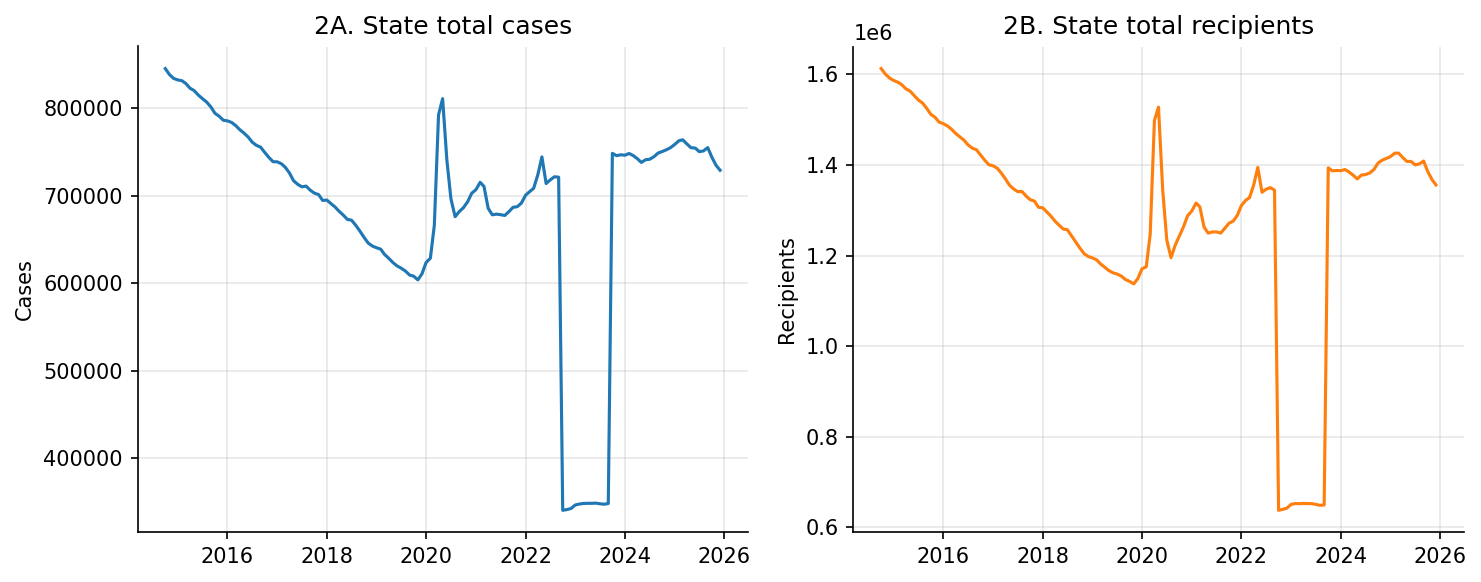

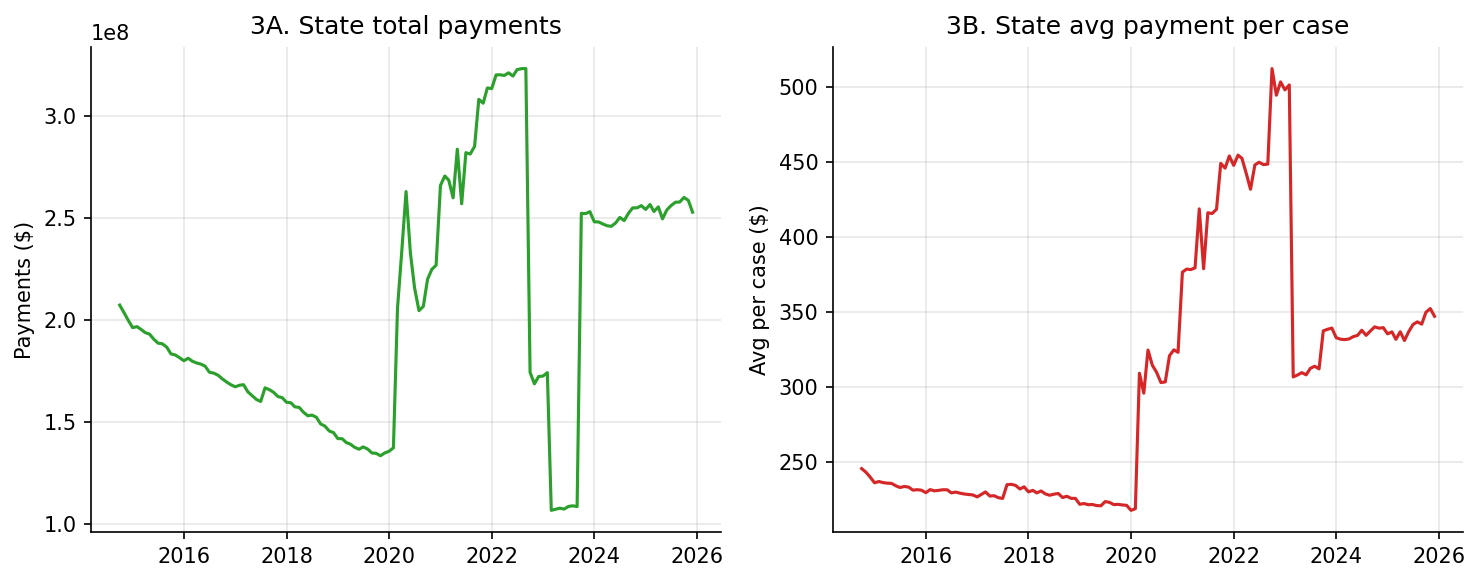

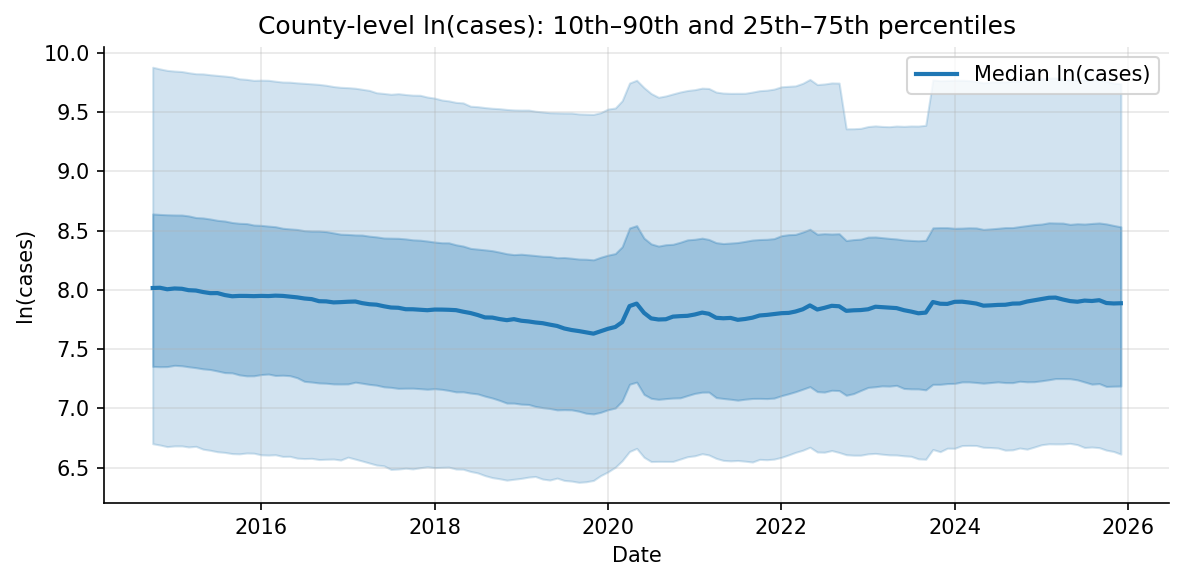

In [3]:
# Run figures in a subprocess (avoids numpy/matplotlib version issues in this kernel)
import os
import sys
import subprocess

cwd = os.getcwd()
project_root = cwd if os.path.basename(cwd) != "R" else os.path.abspath(os.path.join(cwd, ".."))
OUT_DIR = os.path.join(project_root, "outputs", "fap_overview")
script_path = os.path.join(project_root, "R", "fap_figures_overview.py")

# Ensure numpy<2 for the subprocess so matplotlib loads
subprocess.run([sys.executable, "-m", "pip", "install", "numpy<2", "-q"], check=False, timeout=120)
# Generate figures (script writes to outputs/fap_overview/)
r = subprocess.run([sys.executable, script_path], cwd=project_root, capture_output=True, text=True, timeout=60)
if r.returncode != 0:
    print(r.stderr or r.stdout)
    raise SystemError("Figure script failed")
print(r.stdout or "Figures written.")

# Show saved images in notebook
from IPython.display import Image, display
for name in ["fig_2A_2B.png", "fig_3A_3B.png", "fig_county_quantiles.png"]:
    p = os.path.join(OUT_DIR, name)
    if os.path.isfile(p):
        display(Image(filename=p))